## Diffusion Model

Diffusion models roughly consist of two parts: 

- A predefined **forward** diffusion process $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$ of our choosing, that gradually adds Gaussian noise to an image until it becomes pure noise.
- A **reverse** denoising diffusion process $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$, approximated by a neural network, which gradually denoises an image starting from pure noise.


<img src="img/back-forw.png" width="800" align="center"/>

### Diffusion Process Equations

define our **recursive definition**:

$ x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot z_{t-1} $

Where $ z_{t-1} \sim \mathcal{N}(0, I) $ 

**Variance schedule** governs how noise is added over time.

this linear function could be rappresented by analogy distribution point of view:

$ x_t \sim \mathcal{N}(\sqrt{1 - \beta_t} \cdot x_{t-1}, \beta_t) $

let define

$\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$

Let the recursion be:

$$
x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} \, \epsilon_{t-1}
$$

Unrolling the recursion:

$$
= \sqrt{\alpha_t} \left( \sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t-1}} \, \epsilon_{t-2} \right) + \sqrt{1 - \alpha_t} \, \epsilon_{t-1}
$$

$$
= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t-1}} \sqrt{\alpha_t} \, \epsilon_{t-2} + \sqrt{1 - \alpha_t} \, \epsilon_{t-1}
$$

$$
= \ldots
$$

Eventually, we reach:

$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \, \hat{\epsilon}
$$


so we can rewrite

$q(\boldsymbol{x}_t|\boldsymbol{x}_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, 1 - \bar{\alpha}_t)$

this formulation conduct us to a direct sampling:

$ x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot z $

so finally we have no more dependence on $t$

so **we can compute $x_t$ directly, skipping all the steps**


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # for progress bar 
import torch
from torch import nn
import torch.nn.functional as F # for activation functions
from torchvision.transforms import ToPILImage


### Forward process

First, we define the scheduler to compute $\beta_t$.

<img src="img/timesteps.png" width="800" align="center"/>

In [149]:
def linear_beta_schedule(timesteps):

    beta_start = 0.00001 # Initial value of beta
    
    beta_end = 0.01 # Final value of beta
    
    return torch.linspace(beta_start, beta_end, timesteps)

In [150]:
timesteps = 100

# compute betas
betas = linear_beta_schedule(timesteps=timesteps)

for i, beta in enumerate(betas):
    print(f"beta_{i} = {beta.item():.5f}")


beta_0 = 0.00001
beta_1 = 0.00011
beta_2 = 0.00021
beta_3 = 0.00031
beta_4 = 0.00041
beta_5 = 0.00051
beta_6 = 0.00062
beta_7 = 0.00072
beta_8 = 0.00082
beta_9 = 0.00092
beta_10 = 0.00102
beta_11 = 0.00112
beta_12 = 0.00122
beta_13 = 0.00132
beta_14 = 0.00142
beta_15 = 0.00152
beta_16 = 0.00162
beta_17 = 0.00173
beta_18 = 0.00183
beta_19 = 0.00193
beta_20 = 0.00203
beta_21 = 0.00213
beta_22 = 0.00223
beta_23 = 0.00233
beta_24 = 0.00243
beta_25 = 0.00253
beta_26 = 0.00263
beta_27 = 0.00273
beta_28 = 0.00284
beta_29 = 0.00294
beta_30 = 0.00304
beta_31 = 0.00314
beta_32 = 0.00324
beta_33 = 0.00334
beta_34 = 0.00344
beta_35 = 0.00354
beta_36 = 0.00364
beta_37 = 0.00374
beta_38 = 0.00384
beta_39 = 0.00395
beta_40 = 0.00405
beta_41 = 0.00415
beta_42 = 0.00425
beta_43 = 0.00435
beta_44 = 0.00445
beta_45 = 0.00455
beta_46 = 0.00465
beta_47 = 0.00475
beta_48 = 0.00485
beta_49 = 0.00495
beta_50 = 0.00506
beta_51 = 0.00516
beta_52 = 0.00526
beta_53 = 0.00536
beta_54 = 0.00546
beta_55 = 0.00556
be

compute the $\alpha$

In [151]:
# compute alphas (a vector of (1 - beta))
alphas = 1. - betas

# compute alphas cumulative product
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# print the first 10 values of alphas, alphas_cumprod, sqrt_alphas_cumprod, and sqrt_one_minus_alphas_cumprod
print("alphas:")
print(alphas.numpy())
print("alphas_cumprod:")
print(alphas_cumprod.numpy())
print("First 10 values of sqrt_alphas_cumprod:")
print(sqrt_alphas_cumprod.numpy())
print("sqrt_one_minus_alphas_cumprod:")
print(sqrt_one_minus_alphas_cumprod.numpy())

alphas:
[0.99999    0.9998891  0.99978817 0.99968725 0.99958634 0.99948543
 0.9993845  0.9992836  0.9991827  0.9990818  0.9989809  0.99888
 0.9987791  0.9986782  0.9985773  0.9984764  0.9983755  0.99827456
 0.99817365 0.99807274 0.99797183 0.9978709  0.99777    0.9976691
 0.9975682  0.9974673  0.99736637 0.99726546 0.99716455 0.99706364
 0.9969627  0.9968618  0.9967609  0.99666    0.9965591  0.9964582
 0.99635726 0.99625635 0.99615544 0.99605453 0.9959536  0.9958527
 0.9957518  0.9956509  0.99555    0.99544907 0.99534816 0.99524724
 0.99514633 0.9950455  0.9949446  0.99484366 0.99474275 0.99464184
 0.9945409  0.99444    0.9943391  0.9942382  0.9941373  0.9940364
 0.99393547 0.99383456 0.99373364 0.99363273 0.9935318  0.9934309
 0.99333    0.9932291  0.9931282  0.99302727 0.99292636 0.99282545
 0.99272454 0.9926236  0.9925227  0.9924218  0.9923209  0.99222
 0.9921191  0.99201816 0.99191725 0.99181634 0.99171543 0.9916145
 0.9915136  0.9914127  0.9913118  0.99121094 0.99111    0.9910091


[link to dataset](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models)


Load and show image

In [152]:
from PIL import Image
import os

# Path to your folder
folder_path = '/Users/leonardoangellotti/Desktop/universita/master/secondo_semestre/prob_ML/progetto/progetto_v3/dataset'

# Get list of .jpg files
jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

# Load images
images = []

for file in jpg_files:  # Limit to first 100 images
    image_path = os.path.join(folder_path, file)
    img = Image.open(image_path)
    images.append(img)

print(f"Loaded {len(images)} .jpg files.")


Loaded 15747 .jpg files.


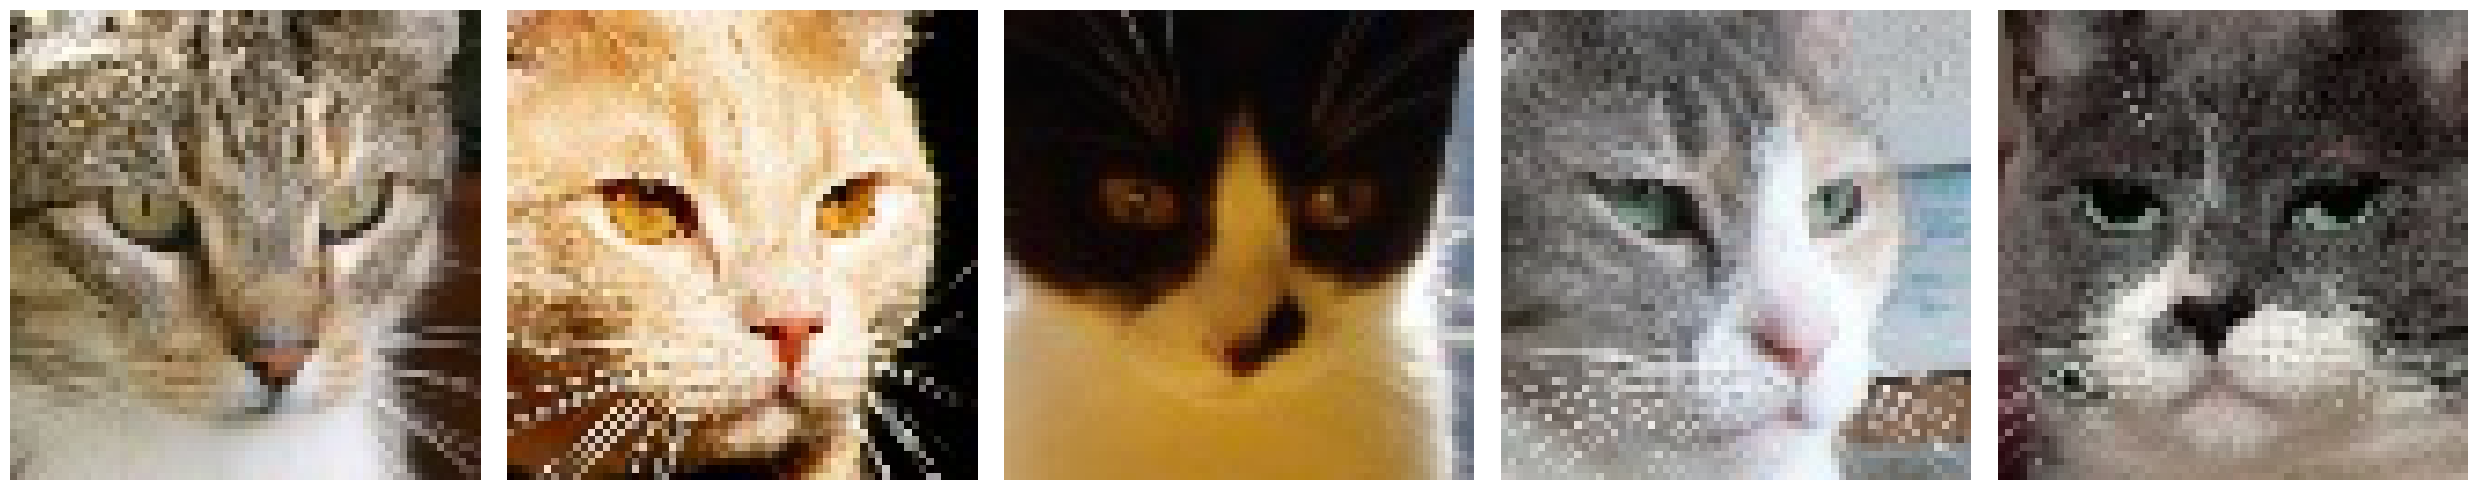

In [153]:
# Display 5 images in a row
plt.figure(figsize=(25, 5))  # 5 images × 5 inches = 25 inches width

for i in range(5):
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
    plt.imshow(images[(i)*1000], cmap='gray')  # Display image in grayscale
    plt.axis('off')

plt.tight_layout()
plt.show()


In [154]:
# images = images[:100]  # Limit to first 100 images for processing

Next, we resize the image, rescale it in $[-1, 1]$, and convert it to a PyTorch tensor.

In [155]:
from torchvision.transforms import Compose, ToTensor, Lambda, Resize, CenterCrop, Grayscale

# Final desired size
resize_size = 28  # Resize shorter side to 64 while keeping aspect ratio

transform = Compose([
    Resize(resize_size),  # Resize shorter side to 64
    Grayscale(num_output_channels=1),  # Convert to grayscale with 1 channels
    ToTensor(),                               # Convert to tensor, scales to [0,1]
    Lambda(lambda t: (t * 2) - 1),            # Normalize to [-1, 1]
])

# Apply transform to each image
tensors = [transform(img) for img in images]  # images should be a list of PIL Images

# Stack into a single batch tensor
x_start = torch.stack(tensors)  # Shape: [n, C, H, W]

# Print shapes
print(x_start.shape)  # Output: torch.Size([n, 3, 128, 128])

torch.Size([15747, 1, 28, 28])


We also define the reverse transform, which maps a PyTorch tensor with in $[−1,1]$ back into a PIL image.

In [156]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # [-1,1] --> [0,1]
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.), # [0,1] --> [0,255]
     Lambda(lambda t: t.numpy().astype(np.uint8)), # convert to numpy array
     ToPILImage(), # convert to PIL Image
])

In [157]:
# Apply to a single image (e.g., first in batch)
img = reverse_transform(x_start[93].cpu())  # Optional .cpu() if tensor is on GPU

img

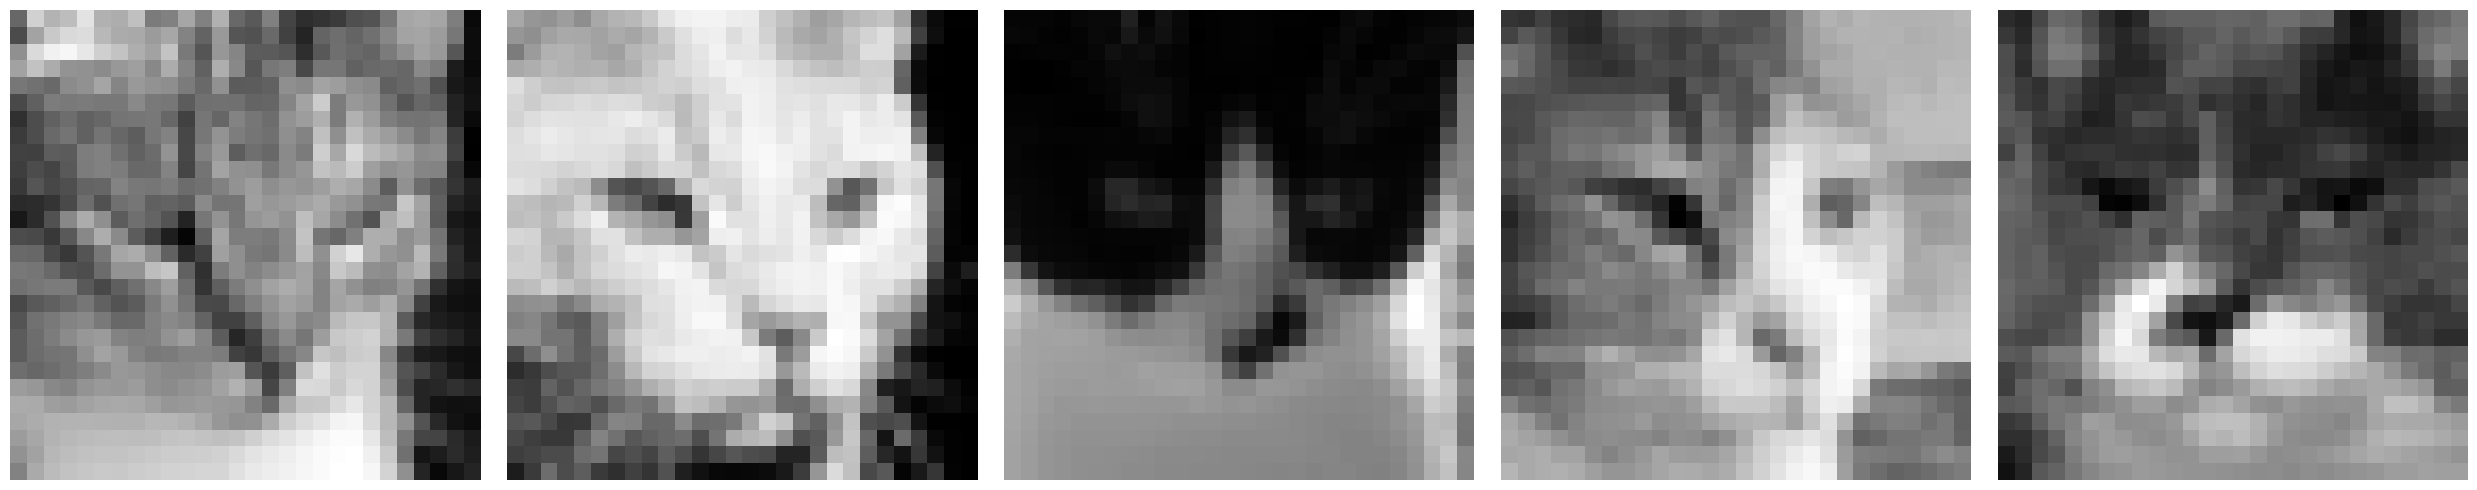

In [158]:
# Display 5 images in a row
plt.figure(figsize=(25, 5))  # 5 images × 5 inches = 25 inches width

for i in range(5):
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
    plt.imshow(reverse_transform(x_start[(i)*1000]),cmap="grey")
    plt.axis('off')

plt.tight_layout()
plt.show()

We can now define the forward diffusion process.

$ x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot z $


In [159]:
def extract(a, t, x_shape):
    """
    This function extracts the values of a tensor a at indices t and reshapes the result to broadcast properly with a tensor of shape x_shape.
    It is typically used to extract time-dependent values (like noise schedule parameters) for each element in a batch, based on a given time-step tensor t.
    
    If x_shape = [4, 3, 64, 64] and t = [2, 5, 7, 9], then:

    α is e.g. [α₀, α₁, ..., α_T].

    α.gather(-1, t) → picks α₂, α₅, α₇, α₉.
    
    .reshape(batch_size, 1, 1, 1) → makes the shape [4, 1, 1, 1] so you can multiply it with x_start using broadcasting.
    """ 
    batch_size = t.shape[0] # number of elements in t
    out = a.gather(-1, t.cpu()) # gather the values at indices t
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # reshape to match x_shape

# forward diffusion process
def q_sample(x_start, t, noise=None):

    if noise is None:
        noise = torch.randn_like(x_start) # noise is sampled from N(0,1) with the same shape as x_start
    
    # extract the appropriate alphas and one minus alphas for the given t
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)

    # print(sqrt_alphas_cumprod_t)

    # extract the appropriate one minus alphas for the given t
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    # print(sqrt_one_minus_alphas_cumprod_t)

    # this is the forward diffusion process
    # x_t is the noisy version of x_start at time t
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

Let's test on a specific time step, $t=200$:

In [160]:
def get_noisy_image(x_start, t):
  
  x_noisy, _ = q_sample(x_start, t=t) # add noise at time t
  
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.cpu()) 
  
  return noisy_image

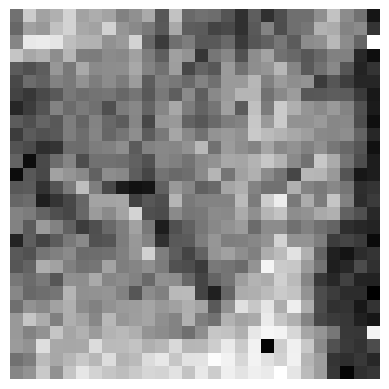

In [161]:
t = torch.tensor([20]) # t = 200, which is the time step we want to sample at
get_noisy_image(x_start[0], t) # Show the noisy image at time t = 200

# image show plt
plt.imshow(get_noisy_image(x_start[0], t), cmap='gray')
plt.axis('off')
plt.show()

In [162]:
def plot_seq(imgs, **imshow_kwargs):

    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs) # number of rows
    num_cols = len(imgs[0]) # number of columns

    # Create a grid of subplots
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    
    # for each row and column, plot the image
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):

            ax = axs[row_idx, col_idx] # Get the subplot for this image
            ax.imshow(np.asarray(img), **imshow_kwargs, cmap="grey") # Plot the image
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # Remove ticks and labels
     

    plt.tight_layout()

### Noise Sequence

Let's illustrate how noise is added to a sample image at each time step of the diffusion process.

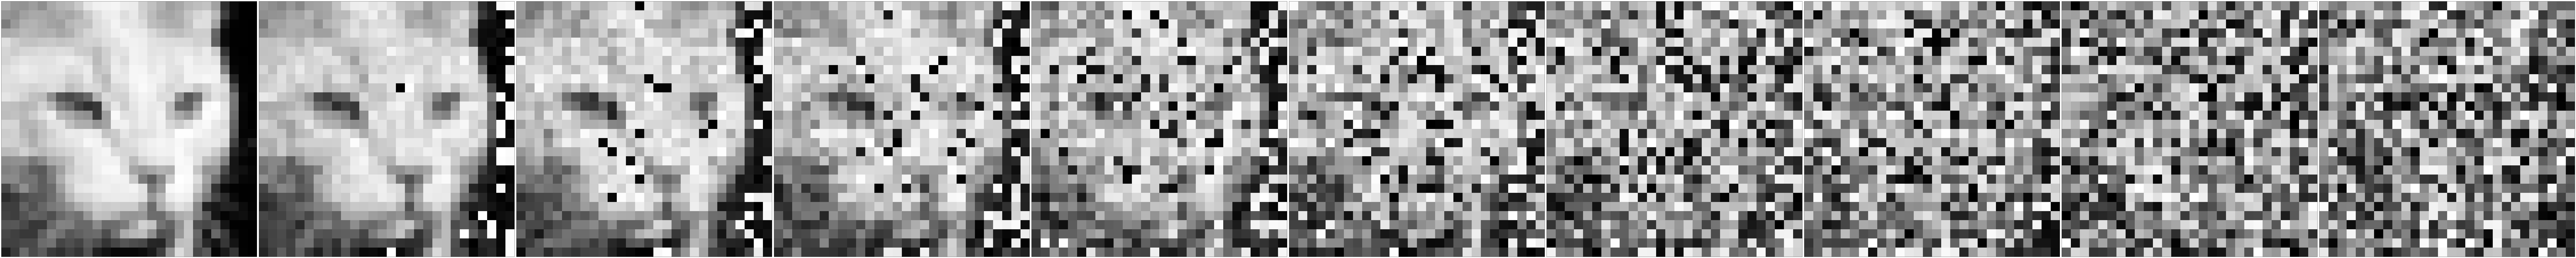

In [163]:
plot_seq([get_noisy_image(x_start[1000], torch.tensor([t])) for t in range(0, 100, 10)])

## backward process

### Why can't we compute $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$ analytically?

Because this distribution depends on the **true data distribution** $p(\mathbf{x}_0)$, which we **don’t have access to**.

Instead, we **approximate** it using a neural network.

### Key Idea: Conditioning on $\mathbf{x}_0$

To simplify, we consider the **posterior** of the forward process:

$$
q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)
$$

This **can** be computed analytically, and it turns out to be a **Gaussian**:

$$
q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}\left(\tilde{\mu}_t(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I} \right)
$$

We use this to define our training objective.

### Simplification for Training

To avoid learning both the mean and variance, we **fix the variance** (or predict it with a simplified parameterization), and focus on predicting the **mean**.

The mean and variance used in this approximation are:

#### **Variance**:

$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t
$$

* This is a **precomputed constant** for each timestep.
* It’s derived from the forward process and doesn't depend on $\mathbf{x}$, so we don't need the network to predict it.

#### **Mean**:

$$
\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \tilde{\boldsymbol{z}}_t \right)
$$

* Here, $\tilde{\boldsymbol{z}}_t$ is the **noise** that was added at time step $t$.
* During training, the model learns to **predict this noise**.

### What does the model learn?

Instead of learning $\tilde{\mu}_t$ directly, we train the model to **predict the noise** $\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)$, and plug that into the equation for $\tilde{\mu}_t$.

This gives us an approximate reverse step:

$$
\mathbf{x}_{t-1} \sim \mathcal{N}\left( \tilde{\mu}_t(\mathbf{x}_t, \boldsymbol{\epsilon}_\theta), \tilde{\beta}_t \mathbf{I} \right)
$$



### NN Model

We approximate $\boldsymbol{\tilde z}_t$ with a NN.

As NN, we use a **Unet**.

the reason why we are gonna use Unet is they excels at capturing **local and global context** useful to denoise images in diffusion models.

Unet are often **timestep-aware** (via sinusoidal embeddings, for example), enabling the model to adapt its denoising strategy based on how much noise is present.

Unet **skip connections** allow the decoder to access fine-grained spatial information from earlier layers.

<figure>
  <img src="img/unet_1.png" width="1000"/>
  <figcaption><strong>Figure:</strong> U-Net architecture used to approximate noise in diffusion models </figcaption>
</figure>


In [164]:
from diffusers import UNet2DModel
import torch.optim as optim

[Define our Unet model using diffusers library by Hugging Face](https://huggingface.co/docs/diffusers/api/models/unet2d)


In [165]:
model = UNet2DModel(

    sample_size=28,           # Image resolution
    in_channels=1,             # RGB
    out_channels=1,            # Predict noise (same shape)
    layers_per_block=4,        # Number of layers in each block
    block_out_channels=(32, 64, 128),  # depth

    # Number of channels in downblock
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),

    # Number of channels in upblock
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Loss

define a simple loss norm-1: $ \| $ $\boldsymbol{ z}_{t-1}$ - $\boldsymbol{\tilde z}_{t}$ $\|_1  = \| $ $\boldsymbol{ z}_{t-1}$ - NN $(\boldsymbol{x}_t, t)$ $\|_1$

$\boldsymbol{ z}_{t-1}$ is the noise used to compute $\boldsymbol{x}_t$ in the forward process

Remember that to compute $\boldsymbol{x}_t$ we dropped the time index on $\boldsymbol{z}$:

$ \boldsymbol{x}_t = \sqrt{\bar \alpha_t} \boldsymbol{x}_0 + \sqrt{1 - \bar \alpha_t} \boldsymbol{z} $

Simply, we can sample $\boldsymbol{z}$, compute $\boldsymbol{x}_t$, and recover $\boldsymbol{z}$ with the $NN$

In [166]:
# loss function
loss_fn = nn.MSELoss()

### Training


The model is trained to denoise images corrupted by varying levels of noise.

At each step, a random timestep is chosen, and the image is noised accordingly.

The model sees the noisy image and the timestep, and learns to predict the noise added.

By minimizing the difference between predicted and true noise, the model learns how to reverse the diffusion (noising) process, and thus generate clean images from noise.

In [167]:
# number of training steps
num_step = int(timesteps * 10)  # 90% of the timesteps
print(f"Number of sampling noise per steps: {num_step}")

Number of sampling noise per steps: 1000


In [168]:
data_img = x_start[:100] # 100 2h / 400 8h

In [169]:
model.train()

# Initialize an empty list to store loss values
loss_arr = []

from torch.utils.data import TensorDataset, DataLoader

dataloader = DataLoader(data_img, batch_size=500, shuffle=True)  # adjust batch_size as needed

# just check the dataloader
for step, i in enumerate(tqdm(dataloader)):
    print(step, i.size())
    break  

  0%|          | 0/1 [00:00<?, ?it/s]

0 torch.Size([100, 1, 28, 28])


In [170]:
for step, x_start_batch in enumerate(tqdm(dataloader)):

    x_start_batch = x_start_batch.to(device)

    # sample num_step of timesteps
    for num_train in range(num_step):

        # Sample a random time step t for each image in the batch
        t = torch.randint(0, timesteps, (x_start_batch.size(0),), device=device).long()

        # Get noisy images and the noise used to create them
        x_noisy, noise = q_sample(x_start_batch, t)

        # Predict the noise
        noise_pred = model(x_noisy, timestep=t).sample

        # Compute loss
        loss = loss_fn(noise_pred, noise)
        loss_arr.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Step {step+1} | Last Batch Loss: {loss.item():.4f}")

100%|██████████| 1/1 [1:57:09<00:00, 7029.99s/it]

Step 1 | Last Batch Loss: 0.0658


Text(0.5, 1.0, 'Training Loss Over Time')

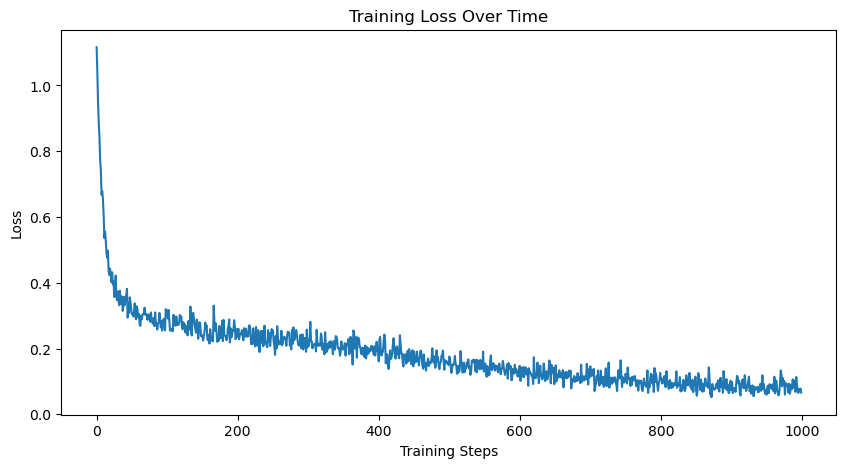

In [171]:
# Plot the loss over time
plt.figure(figsize=(10, 5))
plt.plot(loss_arr, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

In [173]:
# save the model
if not os.path.exists("model"):
    os.makedirs("model")
torch.save(model.state_dict(), "model/diffusion_model_def.pth")


### Sampling

We said that 
$\boldsymbol{x}_{t-1} \sim \mathcal{N} \big( $
$\tilde{\mu}_t$,
$\tilde{\beta}_t$
$\big)$
where
    $\tilde{\beta}_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t$ 
and
    $\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \Big(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}$ 
    $\boldsymbol{\tilde z}_t$ 
    $\Big)$ 

we would define a way to reconstruct original image from noise

<img src="img/sampling.png" width="600" align="center"/>

#### *Sampling algorithm*
$\boldsymbol{x}_T \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ start from a noise random image

**for** $t=T-1, \dots, 0$ **do** (from noise to image timestep)

1) $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ if $t > 1$ else $\boldsymbol{z}=0$ (generate noise)

2) $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \big( \boldsymbol{x}_{t} - \frac{\beta_t}{\sqrt{1 - \bar{ \alpha}_t}}$ NN $(\boldsymbol{x}_t, t)$ $\big) + \tilde \beta_t \boldsymbol{z}$ (based on Unet trained move to the next denoised image)

**return** $\boldsymbol{x}_{0} = \mu_0$ the final image recostructed

In [123]:
@torch.no_grad()
def p_sample_loop(shape, img = None):

    img_array = []  # to store the images generated at each step

    if img is not None:
        # If an initial image is provided, use it
        img = img.to(device)
    else:
        # Generate random noise as the initial image
        img = torch.randn(shape).to(device)

    # for each timestep, we will denoise the image
    for i in reversed(range(timesteps)):

        # Get the current timestep
        t = torch.tensor([i], device=device)

        # Extract the betas
        beta_t = extract(betas, t, img.shape)

        # Extract the alphas
        alpha_t = extract(alphas, t, img.shape)
        
        # Extract the cumulative product of alphas
        alpha_bar_t = extract(alphas_cumprod, t, img.shape)

        # Predict the noise
        noise_pred = model(img, t).sample

        # coefficient1 for the mean calculation
        coef1 = 1 / torch.sqrt(alpha_t)

        # Coefficient2 for the mean calculation
        coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)

        # Calculate the mean of the denoised image
        mean = coef1 * (img - coef2 * noise_pred)

        # If not the last step, add noise to the mean
        if i > 0:
            noise = torch.randn_like(img)
            sigma = torch.sqrt(beta_t)
            img = mean + sigma * noise
            img_array.append(img)

        # If it's the last step, we don't add noise
        else:
            img = mean
            img_array.append(img)

    return img, img_array


### Inference

Once trained, we can sample from the model using the function defined above:

In [174]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # [-1,1] --> [0,1]
     Lambda(lambda t: t * 255.), # [0,1] --> [0,255]
     Lambda(lambda t: t.numpy().astype(np.uint8)), # convert to numpy array
     ToPILImage(), # convert to PIL Image
])

In [175]:
samples = []
transition = []

for i in range(5):  # Generate 5 samples
    s, t = p_sample_loop((1, 1, 28, 28))
    samples.append(s)
    transition.append(t)


In [176]:
reverse_transform(samples[0].squeeze())

In [177]:
# save the samples in a folder
if not os.path.exists("samples"):
    os.makedirs("samples")

# save the samples as images
for i, sample in enumerate(samples):
    sample_pil = reverse_transform(sample.squeeze())
    sample_pil.save(f"samples/sample_{i}.png")

In [178]:
# print shape of samples
print(len(transition[0]))

100


In [179]:
for i in range(5):
    transition[i] = [reverse_transform(t.squeeze()) for t in transition[i]]
    samples[i] = [reverse_transform(s.squeeze()) for s in samples[i]]

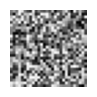

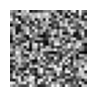

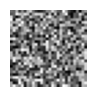

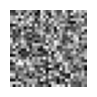

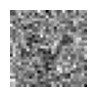

In [180]:
# plot sequence of transition images
for img in transition[0][0:100:20]:
    # image size
    plt.figure(figsize=(1, 1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()